In this self study you will explore Pyro a bit further, bu as opposed to the last self study session where focus was on modeling we will here take a slightly closer lool at (variational) inference. in Pyro 

Before starting on today's self studies, you should finish the self studies from last tme if you have not already done so. Also, if needed, consider revisiting the Pyro documentation listed under reading material for the last two lectures:
* http://pyro.ai/examples/intro_long.html
* http://pyro.ai/examples/bayesian_regression.html
* http://pyro.ai/examples/svi_part_i.html

Afterwards, continue with the notebook below, where we consider (Bayesian) linear regression using Pyro based on the same setup as in the lecture. 

In [1]:
import pyro
import torch
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
import numpy as np

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

c:\Users\Stonker69\Documents\GitHub\ml_exam_notes\selfstudy\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generate data
This data generation is similar to what was done during the lecture; we have one predictor variable 'x' and one response variable 'y', but here collected in a  dictionary.

In [65]:
def generate_data(N=10, true_w0= 1., true_w1=.5):
    gamma = 4.  # The *precision* in the observation noise default:4
    st_dev = 1. / np.sqrt(gamma)  # And corresponding standard deviation
    np.random.seed(123)
    x = 5 * np.random.rand(N)  # The x-points are sampled uniformly on [0, 5]
    y = np.random.normal(loc=true_w0 + true_w1 * x, scale=st_dev)  # And the response is sampled from the Normal
    return {"x": torch.tensor(x, dtype=torch.float), "y": torch.tensor(y, dtype=torch.float)}

Helper function for visualizing the data as well as the true and learned functions

In [59]:
def data_plotter(data, true_w0=None, true_w1=None,
                 approx_w0=None, approx_w1=None, std_w0=None, std_w1=None):
    """
    Use to plot data. If y is not none it contains responses, and (x,y) will be scatter-plotted
    If neither true_w0 nor true_w1 is None, we will plot the line true_w0 + x * true_w1 in red.
    If neither approx_w0 nor approx_w1 is None, we plot the line approx_w0 + x * approx_w1 in green.
    """
    if data is not None:
        plt.plot(data["x"].numpy(), data["y"].numpy(), "bo", zorder=1)

    # Plot true line if given
    if true_w0 is not None and true_w1 is not None:
        plt.plot(data["x"].numpy(), true_w0 + true_w1 * data["x"].numpy(), "r-", zorder=2)

    # Plot approximation if given
    if approx_w0 is not None and approx_w1 is not None:
        plt.plot(data["x"].numpy(), approx_w0+ approx_w1* data["x"].numpy(), "g-", alpha=.2, zorder=2)

    # Plot std if given
    if std_w0 is not None and std_w1 is not None:
        plt.plot(data["x"].numpy(), std_w0+ std_w1* data["x"].numpy(), "grey", alpha=.2, zorder=2)


Generate a data set with 50 data points

In [76]:
true_w0= 1.
true_w1=.5
data = generate_data(N=50, true_w0=true_w0, true_w1=true_w1)

Plot the data together with the regression line around which the data has been generated.

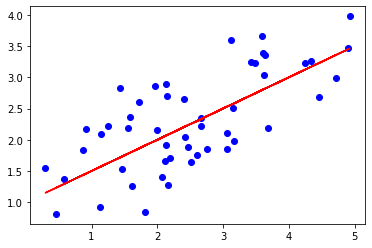

In [77]:
data_plotter(data, true_w0=true_w0, true_w1=true_w1)

## Specification of the Pyro model and guide

Here we specify a (Bayesian) linear regression model in Pyro. The 'data' argument is a dictionary covering the data of the predictor and response variable

In [88]:
def lin_reg_model(data):

    w0 = pyro.sample("w0", dist.Normal(0, 1000))
    w1 = pyro.sample("w1", dist.Normal(0., 1000))

    with pyro.plate("data_plate"):
        pyro.sample("y", dist.Normal(data["x"] * w1 + w0, 1.0), obs=data["y"])

Here we specify the variational distribution, which is called a guide in Pyro. We make the mean field assumption and assume that the variational distribution factorizes wrt. to 'w0' and 'w1'.

In [89]:
def lin_reg_guide(data):
    w0_mean = pyro.param("w0_mean", torch.tensor(0.))
    w0_scale = pyro.param("w0_scale", torch.tensor(1.), constraint=constraints.positive)
    pyro.sample("w0", dist.Normal(w0_mean, w0_scale))
    
    w1_mean = pyro.param("w1_mean", torch.tensor(0.))
    w1_scale = pyro.param("w1_scale", torch.tensor(1.), constraint=constraints.positive)
    pyro.sample("w1", dist.Normal(w1_mean, w1_scale))

### Learning

In this function the actual learning is taking place. Notice that the structure is similar to what we saw in the example notebooks during the lecture.

In [26]:
def learn(N=10, data=None):
    if data is None:
        data = generate_data(N=N)

    pyro.clear_param_store()

    elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model=lin_reg_model,
                         guide=lin_reg_guide,
                         optim=SGD({"lr": 0.0001}),
                         loss=elbo)

    num_steps = 5000
    for step in range(num_steps):
        loss = svi.step(data)

        if step % 100 == 0:
            w0_mean = pyro.param("w0_mean").detach().item()
            w0_scale = pyro.param("w0_scale").detach().item()
            w1_mean = pyro.param("w1_mean").detach().item()
            w1_scale = pyro.param("w1_scale").detach().item()
            print(f"Loss (iter: {step}): {loss}")
            print(f"w0: {w0_mean} +/- {w0_scale}\t \t w1: {w1_mean} +/- {w1_scale}")

In [90]:
learn(data=data)

Loss (iter: 0): 84.80144250392914
w0: 0.0019444664940238 +/- 0.9983436465263367	 	 w1: 0.0004346132045611739 +/- 1.0005890130996704
Loss (iter: 100): 131.75239837169647
w0: 0.3325222134590149 +/- 0.7171316742897034	 	 w1: 0.7421432137489319 +/- 0.33488377928733826
Loss (iter: 200): 76.26693159341812
w0: 0.3896952271461487 +/- 0.5893740057945251	 	 w1: 0.7541874647140503 +/- 0.23502586781978607
Loss (iter: 300): 72.59757429361343
w0: 0.447091668844223 +/- 0.5123016834259033	 	 w1: 0.7207613587379456 +/- 0.1987530142068863
Loss (iter: 400): 77.12668907642365
w0: 0.513460636138916 +/- 0.45435404777526855	 	 w1: 0.7397116422653198 +/- 0.17133556306362152
Loss (iter: 500): 70.9093565940857
w0: 0.5389812588691711 +/- 0.4105273485183716	 	 w1: 0.668910801410675 +/- 0.15343531966209412
Loss (iter: 600): 71.83397114276886
w0: 0.5828987956047058 +/- 0.3846311867237091	 	 w1: 0.6577913165092468 +/- 0.14453881978988647
Loss (iter: 700): 123.50280380249023
w0: 0.6278696656227112 +/- 0.3577805459499

### Analyze the results

Here we sample weights from the posterior distributions over 'w0' and 'w1'. The distribution of the generated weights (and the corresponding models) illustrates how confident we are in the model, an insight you cannot get when only having point estimates of the model parameters as found with, e.g., maximum likelihood learning. 

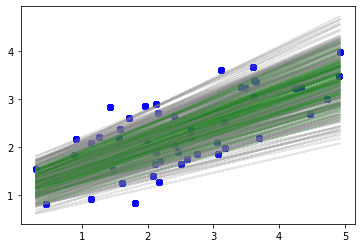

In [91]:
for _ in range(100):
    w0_mean = pyro.param("w0_mean").detach().item()
    w0_scale = pyro.param("w0_scale").detach().item()
    w1_mean = pyro.param("w1_mean").detach().item()
    w1_scale = pyro.param("w1_scale").detach().item()
    w0_sample = pyro.sample("w0_sample", dist.Normal(w0_mean, w0_scale)).numpy()
    w1_sample = pyro.sample("w1_sample", dist.Normal(w1_mean, w1_scale)).numpy() 
    data_plotter(data, approx_w0=w0_sample, approx_w1=w1_sample)
    # plot gray 1 std uncertainty lines, gaussian so 68% data expect within 1 std
    # plot gray std_above 
    data_plotter(data, std_w0=w0_sample+w0_scale, std_w1=w1_sample+w1_scale)
    #plot gray std_above
    data_plotter(data, std_w0=w0_sample-w0_scale, std_w1=w1_sample-w1_scale)
data_plotter(data)
plt.show()

## Exercises:
        * Generate data sets of varying sizes and characteristics (by changing the parameters in the 'generate_data' function) and investigate and compare the resulting models.


__default__:
- True model: y = 1 + 0.5 * x, samples = 50 (DEFAULT)
- Sensor precision: 1/sqrt(4) (DEFAULT)
- Learned model: w0 = N(1.1,0.18) | w1 = N(0.46, 0.065)
- we most points within 1 std, which is a good sign
![](images/pyro_lin_default.png)

__sample=10__:
- True model: y = 1 + 0.5 * x, samples = 10 (will try lowering the number of samples expect more variance)
- Sensor precision: 1/sqrt(4) (DEFAULT)
- Learned model: w0 = N(0.64,0.38) | w1 = N(0.7, 0.13)
- Conclusion: more variance + more away from true model
![](images/pyro_lin_sample10.png)
- we see all points mostly within 1 std often, but we can see much vairance in estimating the intercept/bias w0, sometimes even it gets 2, which is double of true 1

__Sensor precision=1/sqrt(1)__:
- True model: y = 1 + 0.5 * x, samples = 50 (DEFAULT)
- Sensor precision: 1/sqrt(1) (decreasing sensor precision, expect more variance)
- Learned model: w0 = N(1.25,.18) | w1 = N(0.44, 0.064)
- Conclusion: more variance + more away from true model + in the plot, majority of dots were ouside the approx drawn lines
- we plot 1 std. gray (68% data < 1std 3-sigma rule) uncertainity boundaries and we see that much data is outside the 1std 
  line, which is not a good signal
![](images/pyro_lin_sensor1.png)

__Sensor precision=1/sqrt(8)__:
- True model: y = 1 + 0.5 * x, samples = 50 (DEFAULT)
- Sensor precision: 1/sqrt(8) (doubling sensor precision, expect less variance)
- Learned model: w0 = N(1.09,0.17) | w1 = N(0.49, 0.063)
- Conclusion: more or less similar to default, so doubling sensor quality does not give double performance
![](images/pyro_lin_sensor8.png)
- we see more points within gray 1 std. but it did not give double performance compared to sensor with 4, as sensor only minimize std with sqrt(sensor)

__Samples = 1000__:
- True model: y = 1 + 0.5 * x, samples = 1000 (increase samples a lot, expect less variance)
- Sensor precision: 1/sqrt(4) (DEFAULT)
- Learned model: w0 = N(1.02,0.04) | w1 = N(0.494, 0.014)
- Conclusion: best model yet (samples = 1000)
![](images/pyro_lin_sample1000.png)
- more data is better, it is more or less exact on the true

        * Analyze how learning is affected by changing the learning rate and the initial values of the parameters specified in the guide function.


Using default data setup: 
- True model: y = 1 + 0.5 * x, samples = 50 (DEFAULT)
- Sensor precision: 1/sqrt(4) (DEFAULT)
- lr = 0.0001 (DEFAULT)
- w0_mu = 0, w0_sigma = 1 (DEFAULT)
- w1_mu = 0, w1_sigma = 1 (DEFAULT)
- learned model: w0 = N(1.1,0.18) | w1 = N(0.46, 0.065)

__lr = 0.001__:
- lr = 0.001 (increasing lr)
- w0_mu = 0, w0_sigma = 1 (DEFAULT)
- w1_mu = 0, w1_sigma = 1 (DEFAULT)
- learned model: w0 = N(1.15,0.14) | w1 = N(0.47, 0.049)
- Conclusion: similar to default, 

__lr = 0.01__:
- lr = 0.01 (increasing lr)
- w0_mu = 0, w0_sigma = 1 (DEFAULT)
- w1_mu = 0, w1_sigma = 1 (DEFAULT)
- Crashes in leaning here: " Expected parameter scale (Tensor of shape ()) of distribution Normal(loc: 13.8917818069458, scale: 0.0) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
0.0"

__moving priors far away from true model__:
- w0_mu = -10, w0_sigma = 1 
- w1_mu = 10, w1_sigma = 1 
- lr = 0.0001 (DEFAULT)
- learned model: w0 = N(0.89, 0.18) | w1 = N(0.55, 0.065)
- Conclusion: a bit off from true model, but still pretty close

__increasing confidence in wrong guide params__:
- w0_mu = -10, w0_sigma = 0.001 
- w1_mu = 10, w1_sigma = 0.001 
- lr = 0.0001 (DEFAULT)
- learned model: w0 = N(.89, 0.001) | w1 = N(.55, 0.001)
- conclusion: a bit off from true model, but still pretty close, low variance

        * Experiment with different types of prior knowledge in the model specification (e.g. change the mean and scale of the distributions over the weights). For instance, we may (mostly likely erroneously considering the data) have a prior expectation that 'w0' is around 5.0, and we can encode the strength of this belief through the scale of the corresponding distribution. 

Using default data setup: 
- True model: y = 1 + 0.5 * x, samples = 50 (DEFAULT)
- Sensor precision: 1/sqrt(4) (DEFAULT)
- lr = 0.0001 (DEFAULT)
- w0_mu = 0, w0_sigma = 1 (DEFAULT)
- w1_mu = 0, w1_sigma = 1 (DEFAULT)
- prior model: 
    - w0 = pyro.sample("w0", dist.Normal(0.0, 1000.0))
    - w1 = pyro.sample("w1", dist.Normal(0.0, 1000.0))

__moving locs far away from true model__:
- w0 = pyro.sample("w0", dist.Normal(-100.0, 1000.0))
- w1 = pyro.sample("w1", dist.Normal(100.0, 1000.0))
- learned model: w0 = N(1.14, 0.18) | w1 = N(0.55, 0.065) 
- conclusion: little impact from default

__increasing confidence in prior__:
- w0 = pyro.sample("w0", dist.Normal(0.0, 0.01))
- w1 = pyro.sample("w1", dist.Normal(0.0, 0.01))
- learned model: w0 = N(-0.0007222937420010567,0.012490347027778625), w1 = N(0.052780792117118835,0.012352855876088142)
- conclusion: increadibly wrong, increasing confidence in wrong prior is most detrimental